<a href="https://colab.research.google.com/github/Sajish06/task1/blob/main/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn joblib

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Titanic-Dataset.csv to Titanic-Dataset (1).csv


In [5]:
import pandas as pd
df = pd.read_csv('Titanic-Dataset (1).csv')   # or use the correct filename
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [7]:
print(df.shape)
print(df.dtypes)

missing = df.isnull().sum().sort_values(ascending=False)
print(missing[missing>0])

df.describe(include='all').T

(891, 12)
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object
Cabin       687
Age         177
Embarked      2
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Dooley, Mr. Patrick",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


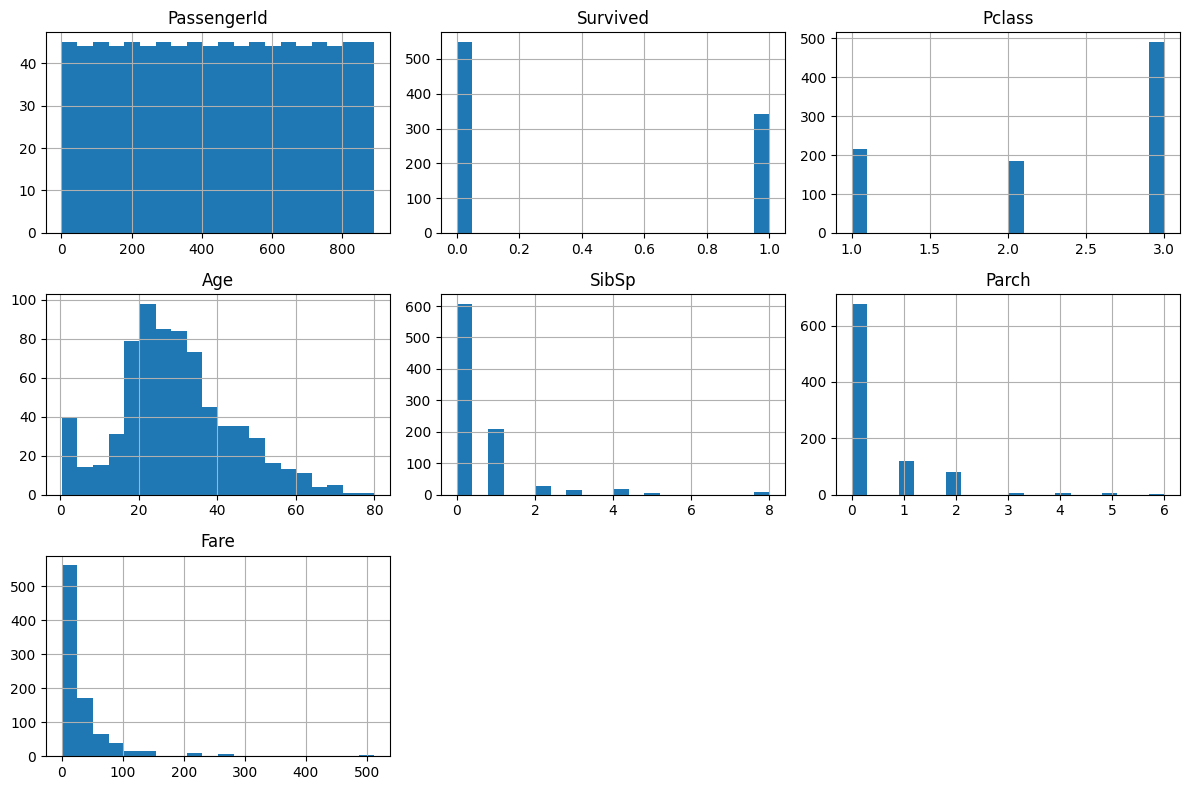

In [8]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
df[num_cols].hist(figsize=(12,8), bins=20)
plt.tight_layout()

sns.countplot(x='Survived', data=df)
plt.title('Survived distribution')
plt.show()


In [9]:
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Mlle','Ms'],'Miss').replace('Mme','Mrs')

rare_titles = df['Title'].value_counts()[df['Title'].value_counts()<10].index
df['Title'] = df['Title'].replace(rare_titles, 'Rare')

df['Deck'] = df['Cabin'].fillna('Unknown').str[0]
df['Deck'] = df['Deck'].replace('U','Unknown')

df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

df = df.drop(columns=['Cabin','Ticket','Name'])


In [11]:
target = 'Survived'
features = [c for c in df.columns if c != target]

num_features = df.select_dtypes(include=['int64','float64']).columns.drop(target).tolist()
cat_features = df.select_dtypes(include=['object','category']).columns.tolist()

print("Numeric:", num_features)
print("Categorical:", cat_features)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

Numeric: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical: ['Sex', 'Embarked', 'Title', 'Deck']


In [12]:
def remove_outliers_iqr(df_, cols):
    df = df_.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        low = Q1 - 1.5 * IQR
        high = Q3 + 1.5 * IQR
        df = df[(df[col] >= low) & (df[col] <= high)]
    return df

df_no_out = remove_outliers_iqr(df, ['Fare','Age'])
print(df.shape, '->', df_no_out.shape)

(891, 11) -> (708, 11)


In [13]:
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = Pipeline([
    ('preproc', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8044692737430168
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       110
           1       0.77      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179



In [15]:
df.to_csv('titanic_cleaned.csv', index=False)

In [16]:
from google.colab import files
files.download('titanic_cleaned.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>